# Simple Epidemic Model

We are simulating a simple epidemic model on an Erdos-Renyi network. Each node is an individual and each edge represents connections between individuals. A connection between two individuals exists if they have come into contact with each other so as to allow the infection to spread.

Each individual can be in one of 3 states
* Susceptible
* Infected
* Recovered

For now we are ignoring death of an individual and quarantining for the purposes of this illustration

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy
import scipy 
import networkx
import time as ttclock

from IPython.display import display, clear_output

%matplotlib inline

## Case I 

In the first case each person can be only in one of two states `susceptible` or `infected`, i.e., there is no immunity gained after recovering from an infection.

In [2]:
def initialize_network(population_size, link_probability, initial_infected_ratio):
    """Initialize the network

    Parameters
    ----------
    population_size: int
        The total number of nodes in the network.

    link_probability: float
        The probability of contact between any two individuals on the network

    initial_infected_ratio: float
        The fraction of the population that are in the infected state at t=0
    
    Returns
    -------
    network: NextworkX network object
        An Erdos-Renyi graph (N = population_size, p = link_probability)

    positions: NetworkX layout object
        Used for visualization of the network. We are using a random layout
    """
    network = networkx.erdos_renyi_graph(population_size, link_probability)
    positions = networkx.random_layout(network)
    for i in network.nodes():
        if random.random() < initial_infected_ratio:
            network.nodes[i]['state'] = infected
        else:
            network.nodes[i]['state'] = susceptible

    return network, positions

In [3]:
def step(network, iteration, infection_probability, recovery_probability, susceptible=0, infected=1):
    """Perform a single iteration on the network

    Parameters
    ----------
    network: NetworkX network object
        The current state of the network

    iteration: int
        Iteration counter

    infection_probability: float
        Probability that an individual will be infected when they come into contact with
        another individual
    
    recovery_probability: float
        Probability that an infected individual will recover in the time period of this 
        iteration

    susceptible: int
        The state value in the network used for susceptible person. Default is 0

    infected: int
        The state value in the network used for an infected person. Default is 1

    Returns
    -------
    next_network: NetworkX network object
        End state of the network after the iteration
    """
    iteration += 1
    next_network = network.copy()
    for i in network.nodes():
        if network.nodes[i]['state'] == susceptible:
            next_network.nodes[i]['state'] = susceptible
            for j in network.neighbors(i):
                if network.nodes[j]['state'] == infected:
                    if random.random() < infection_probability:
                        next_network.nodes[i]['state'] = infected
                        break
        else:
            if random.random() < recovery_probability:
                next_network.nodes[i]['state'] = susceptible
            else:
                next_network.nodes[i]['state'] = infected

    return next_network

def run(network, positions, infection_probability, recovery_probability, niterations=50, sleep_time=1):
    """Function to run the network dynamics

    Parameters
    ----------
    network: NetworkX network object
        The initialized network object

    positions: NetworkX layout object
        Network layout used for plotting and visualization

    infection_probability: float
        Probability that an individual will be infected when they come into contact with
        another individual
    
    recovery_probability: float
        Probability that an infected individual will recover in the time period of this 
        iteration

    niterations: int
        Number of iterations to perform. Default is 50

    sleep_time: float
        Time interval to wait for before plot is updated

    Returns
    -------
    total_infected: list
        The total number of infected people at each iteration
    """
    total_infected = []
    total_susceptible = []
    iteration = 0
    fig = plt.figure(figsize=(8.0, 8.0))
    ax = fig.add_subplot(1,1,1)
    persons_infected = [n for n in network.nodes() if network.nodes[n]['state'] == 1]
    total_infected.append(len(persons_infected))
    while iteration < niterations:
        iteration += 1
        next_network = step(network, iteration, infection_probability, recovery_probability)
        network = next_network.copy()
        persons_infected = [n for n in network.nodes if network.nodes[n]['state'] == 1]
        total_infected.append(len(persons_infected))
        ax.cla()
        networkx.draw(network, pos = positions,
                  node_color = [network.nodes[i]['state'] for i in network.nodes()],
                  with_labels = False, edge_color = 'c', vmin = 0, vmax = 1, ax=ax)
        ax.set_title('t = {}'.format(iteration))
        display(fig)
        clear_output(wait = True)
        plt.pause(sleep_time)
    return total_infected

Text(0.5, 1.0, 't = 0')

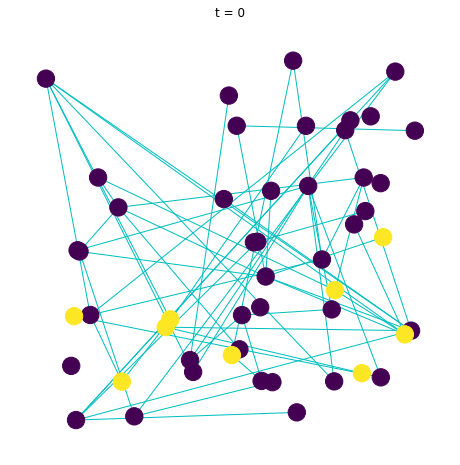

In [4]:
# Set the properties of the network
random.seed()
population_size = 50
link_probability = 0.05    
initial_infected_ratio = 0.2
infection_probability = 0.2
recovery_probability = 0.5
susceptible = 0
infected = 1

# Initialize the network and plot
network, positions = initialize_network(population_size, link_probability, initial_infected_ratio)
fig = plt.figure(figsize=(8.0, 8.0))
ax = fig.add_subplot()
networkx.draw(network, pos = positions,
              node_color = [network.nodes[i]['state'] for i in network.nodes()],
              with_labels = False, edge_color = 'c', vmin = 0, vmax = 1, ax = ax)
ax.set_title('t = {}'.format(0))

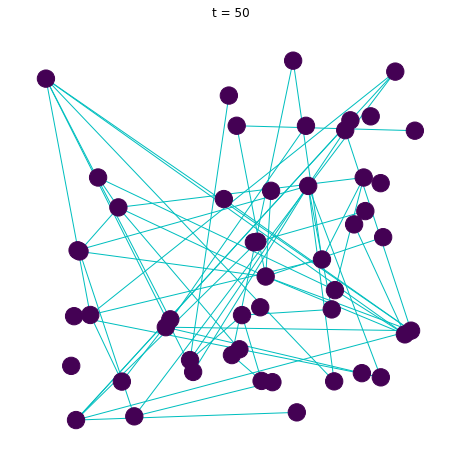

In [5]:
total_infected = run(network, positions, infection_probability, recovery_probability)

Text(0, 0.5, 'Total infected')

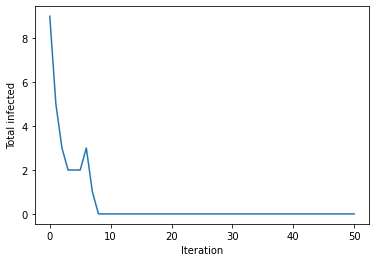

In [6]:
fig = plt.figure()
ax = fig.add_subplot() 

x = numpy.arange(0, len(total_infected), 1)
y = numpy.array(total_infected)
  
ax.plot(x, y)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total infected')


# Case 2

In this case, let us add two criteria :
* an infected person remains sick for a small time period
* a person who has recovered from infection cannot be reinfected for a small period of time, i.e., there is limited immunity. 

A lot of viral infections follow this pattern

Note that the initialization function is unchanged and we are only changing the step and run functions and managing the immunity and infection period using increments and decrements of the 'state' variable in the network. We provide the whole code in a single block.

In [7]:
def step(network, iteration, infection_probability, recovery_probability, susceptible=0, infected=1, 
         infected_period=5, immunity_period=10):
    """Perform a single iteration on the network

    Parameters
    ----------
    network: NetworkX network object
        The current state of the network

    iteration: int
        Iteration counter

    infection_probability: float
        Probability that an individual will be infected when they come into contact with
        another individual
    
    recovery_probability: float
        Probability that an infected individual will recover in the time period of this 
        iteration

    infected_period: int
        The time period (in iterations) for which a person remains infectious and 
        capable of spreading disease

    immunity_period: int
        The time period (in iterations) for which a person who has recovered from
        infection is not susceptible to reinfection

    susceptible: int
        The state value in the network used for susceptible person. Default is 0

    infected: int
        The state value in the network used for an infected person. Default is 1


    Returns
    -------
    next_network: NetworkX network object
        End state of the network after the iteration
    """
    iteration += 1
    next_network = network.copy()
    for i in network.nodes():
        if network.nodes[i]['state'] == susceptible:
            next_network.nodes[i]['state'] = susceptible
            for j in network.neighbors(i):
                if network.nodes[j]['state'] >= 1:
                    if random.random() < infection_probability:
                        next_network.nodes[i]['state'] = infected
                        break
        elif network.nodes[i]['state'] > infected_period + 1: 
            if random.random() < recovery_probability:
                next_network.nodes[i]['state'] = -immunity_period
            else:
                next_network.nodes[i]['state'] += 1   
        elif network.nodes[i]['state'] < 0:
            next_network.nodes[i]['state'] += 1
        elif network.nodes[i]['state'] >= 1:
            next_network.nodes[i]['state'] += 1

    return next_network

def run(network, positions, infection_probability, recovery_probability,
        infected_period=5, immunity_period=10, niterations=100, sleep_time=1):
    """Function to run the network dynamics

    Parameters
    ----------
    network: NetworkX network object
        The initialized network object

    positions: NetworkX layout object
        Network layout used for plotting and visualization

    infection_probability: float
        Probability that an individual will be infected when they come into contact with
        another individual
    
    recovery_probability: float
        Probability that an infected individual will recover in the time period of this 
        iteration

    infected_period: int
        The time period (in iterations) for which a person remains infectious and 
        capable of spreading disease

    immunity_period: int
        The time period (in iterations) for which a person who has recovered from
        infection is not susceptible to reinfection

    niterations: int
        Number of iterations to perform. Default is 50

    sleep_time: float
        Time interval to wait for before plot is updated

    Returns
    -------
    total_infected: list
        The total number of infected people at each iteration
    """
    state_counts = []
    iteration = 0
    persons_infected = [n for n in network.nodes() if network.nodes[n]['state'] >= 1]
    persons_susceptible = [n for n in network.nodes() if network.nodes[n]['state'] == 0]
    persons_immune = [n for n in network.nodes() if network.nodes[n]['state'] < 0]

    state_counts.append((len(persons_infected), len(persons_susceptible), len(persons_immune)))
    while iteration < niterations:
        iteration += 1
        next_network = step(network, iteration, infection_probability, recovery_probability)
        network = next_network.copy()
        persons_infected = [n for n in network.nodes if network.nodes[n]['state'] >= 1]
        persons_susceptible = [n for n in network.nodes() if network.nodes[n]['state'] == 0]
        persons_immune = [n for n in network.nodes() if network.nodes[n]['state'] < 0]

        state_counts.append((len(persons_infected), len(persons_susceptible), len(persons_immune)))
    return state_counts

# Set the properties of the network
random.seed()
population_size = 50
link_probability = 0.05    
initial_infected_ratio = 0.2
infection_probability = 0.5
recovery_probability = 0.3
susceptible = 0
infected = 1

# Initialize the network and plot
network, positions = initialize_network(population_size, link_probability, initial_infected_ratio)
state_counts = run(network, positions, infection_probability, recovery_probability)

Text(0, 0.5, 'State counts')

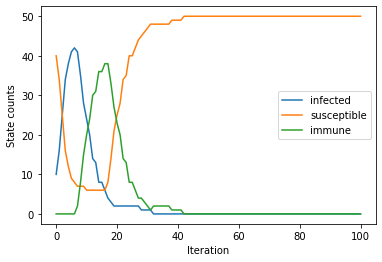

In [8]:
fig = plt.figure()
ax = fig.add_subplot() 

state_counts = numpy.array(state_counts)
x = numpy.arange(0, len(state_counts[:,0]), 1)
y1 = numpy.array(state_counts[:,0])
y2 = numpy.array(state_counts[:,1])
y3 = numpy.array(state_counts[:,2])
  
ax.plot(x, y1, label='infected')
ax.plot(x, y2, label='susceptible')
ax.plot(x, y3, label='immune')
ax.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('State counts')